In [277]:
include("../scripts/tools.jl")
include("../scripts/get_grid.jl")
include("../scripts/get_params.jl")
include("../scripts/plotting.jl")
include("../scripts/stable.jl")
include("../scripts/dynamics.jl")
include("../scripts/disturbances.jl")
include("../scripts/ps_analysis.jl");
include("../scripts/disc_solvers.jl");
using LinearAlgebra
using Statistics

In [2]:
border, scale_factor = import_border("../data/borders/border.json")

dx = 0.005
mesh = get_grid(border, dx); # renamed to be able to use the grid function for plotting

In [237]:
# compute or load grid parameters
contmod = get_params(mesh, scale_factor, "../data/disc/pantagruel.h5", Niter=60,
    dmax = 2*dx, patch=4000.0, bmin=0.0, tau=0.00001);

  2.766125 seconds (529.83 k allocations: 16.811 GiB, 4.36% gc time)
  6.718253 seconds (18.52 k allocations: 5.442 GiB, 13.03% gc time)


In [4]:
# save initial quantities
isgrid = copy(contmod.isgrid)
m0 = copy(contmod.m)
d0 = copy(contmod.d)
p0 = copy(contmod.p)
bx0 = copy(contmod.bx)
by0 = copy(contmod.by);

In [5]:
# create the list of edges
# the following is incomplete but should be sufficient
epsilon = Int64.(zeros(4*contmod.Nx*contmod.Ny, 2))
l = 1

for k in 1:contmod.Nx*contmod.Ny
    if(contmod.isinside[k])
        epsilon[l,:] = [k k+contmod.Ny]
        epsilon[l+1,:] = [k k+1]
        l +=2
    end
end

for id in 1:size(contmod.n,1)
    k = (Int64(contmod.n[id, 2]) - 1) * contmod.Ny + Int64(contmod.n[id, 1])
    ny = contmod.n[id, 3]
    nx = contmod.n[id, 4]
    if(nx == 0)
        epsilon[l,:] = [k k+contmod.Ny]
        #epsilon[l+1,:] = [k k-contmod.Ny]
        #l +=2
        l +=1
    elseif(nx == -1)
        epsilon[l,:] = [k k+contmod.Ny]
        l +=1
    elseif(nx == 1)
        #epsilon[l,:] = [k k-contmod.Ny]
        #l +=1
    end
    if(ny == 0)
        epsilon[l,:] = [k k+1]
        #epsilon[l+1,:] = [k k-1]
        l +=1
    elseif(ny == -1)
        epsilon[l,:] = [k k+1]
        l +=1
    elseif(ny == 1)
        #epsilon[l,:] = [k k-1]
        #l +=1
    end
end

epsilon = epsilon[1:l-1,:]

epsilon_new = Int64.(zeros(size(epsilon)))
id = findall(contmod.isgrid)
n = length(id)
#id = findall(contmod.isborder)
#println(id)
for i = 1:length(id)
    id1 = (epsilon[:,1] .== id[i])
    id2 = (epsilon[:,2] .== id[i])
    epsilon_new[id1,1] .= i
    epsilon_new[id2,2] .= i
end

grid_coord = contmod.coord[contmod.isgrid, :];

In [6]:
# DONT DO THIS PLOT IF dx is smaller than ~0.05
if(dx >= 0.05)
    plot(aspect_ratio=:equal, legend=false)
    for k = 1:size(epsilon_new,1)
        if(epsilon_new[k,1] != 0 && epsilon_new[k,2] != 0)
            #println(coord[[epsilon_new[k,1] epsilon_new[k,2]],2],)
            plot!(vec(grid_coord[[epsilon_new[k,1] epsilon_new[k,2]],2]),
                vec(grid_coord[[epsilon_new[k,1] epsilon_new[k,2]],1]),color=:black)
        end
    end
    scatter!(contmod.coord[contmod.isgrid,2], contmod.coord[contmod.isgrid,1])

    current()
end


In [7]:
N = size(epsilon_new,1)
id1 = [epsilon_new[:,1];epsilon_new[:,2]]
id2 = vec([1:N 1:N])
v = [-ones(N); ones(N)]
B = sparse(id1, id2, v)
L = B*B'

if(dx >= 0.01)
    Lfull = Array{Float64,2}(L)
    res = eigen(Lfull);
    temp = zeros(size(contmod.isgrid))
    temp[contmod.isgrid] = vec(res.vectors[:,3])
    hm_plot(contmod, temp; borders=[border])
end

In [211]:
# perform Lanczos Algorithm

v = rand(n,1)
v = v .- mean(v)
#v = ones(n,1)
v = v / norm(v)

w =  L * v
alpha = dot(w, v)
w = w - alpha * v

V = v
as = alpha
bs = []

Ncut = 1500 # don't go to high or the eigenvectors you get do not satisfy sum(v)=0 any more

for i=2:Ncut
    beta = norm(w)
    if(beta > 1E-6)
        v = w / beta
    else
        println("CAWABUNGA")
        v = rand(n, 1)
        for j=1:i-1
            v -= dot(v, V[:,j]) * V[:,j]
        end
        v  /= norm(v)
    end

    w = L * v
    alpha = dot(w, v)
    w = w - alpha * v - beta * V[:,i-1]
    bs = [bs; beta]
    as = [as alpha]
    V = [V v]
end


T = zeros(Ncut, Ncut)
for i=1:Ncut
    T[i,i] = as[i]
end
for i=1:Ncut-1
    T[i, i+1] = bs[i]
    T[i+1, i] = bs[i]
end

res2 = eigen(T)



In [214]:
# postprocessing
VV = V * res2.vectors[:,2:end];
for i=1:size(VV,2)
    if(sum(VV[:,i])>1)
        println(i)
    end
    VV[:,i] .-= mean(VV[:,i])
    VV[:,i] ./= norm(VV[:,i])
end
#eigv = round.(1000*res2.values)
#id = indexin(unique(eigv), eigv)
#VV = VV[:,id];

In [205]:
#VVnew 

s=zeros(Ncut)
for i=1:Ncut
    s[i] = sum(VV[:,i])  
end
#res2.values[1:20]
#plot(s[1:end])

#size(VV)
#Ncut

14597×1435 Matrix{Float64}:
  0.00225553  0.00815095  -0.0026504   …   5.25284e-7    8.81517e-8
  0.00223199  0.00814868  -0.00264789     -1.06156e-6   -1.78209e-7
  0.00220166  0.00814487  -0.0026437       1.31676e-6    2.21189e-7
  0.00217849  0.00814092  -0.00263936     -1.03134e-6   -1.73399e-7
  0.00188031  0.00800938  -0.00249439      2.36298e-6    4.03516e-7
  0.00191378  0.00799929  -0.00248332  …  -3.7163e-6    -6.35731e-7
  0.00194271  0.00798557  -0.00246832      4.02234e-6    6.89515e-7
  0.0019394   0.00797136  -0.00245284     -3.69618e-6   -6.35046e-7
  0.00194204  0.0079602   -0.00244072      2.31908e-6    3.99399e-7
  0.00238553  0.00814973  -0.00264925      5.56911e-7    9.34733e-8
  0.00231718  0.00814888  -0.00264826  …  -2.08768e-6   -3.50449e-7
  0.00227     0.00814588  -0.00264494      3.46076e-6    5.81194e-7
  0.00221283  0.00814067  -0.00263921     -4.48473e-6   -7.53702e-7
  ⋮                                    ⋱                
 -0.0142367   0.00979281   0.00

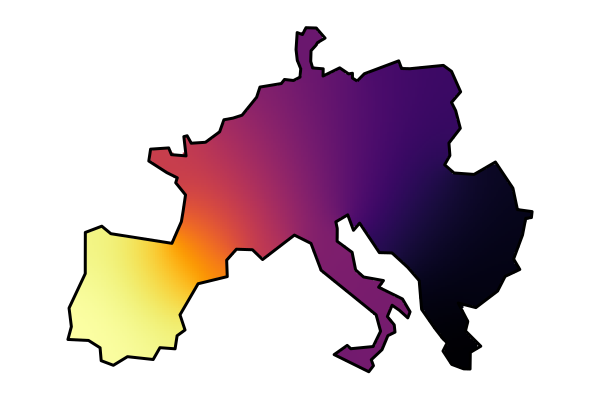

In [216]:
temp = zeros(size(contmod.isgrid))
temp[contmod.isgrid] = vec(VV[:,2])
hm_plot(contmod, temp; borders=[border])

181.465741
181.46574099999998
29.079817650509998
14.979709809693816
3.80554301634943
1.6947318133453935


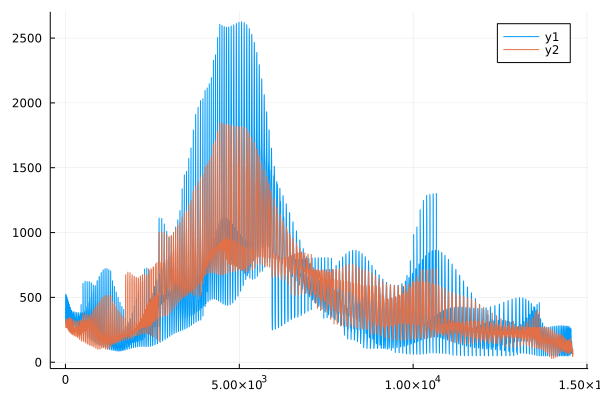

In [278]:
# project the quantities over the modes

mred = zeros(size(contmod.m))
dred = zeros(size(contmod.d))
pred = zeros(size(contmod.p))
bxred = zeros(size(contmod.bx))
byred = zeros(size(contmod.by))
mred[isgrid] .= mean(m0[isgrid])

dred[isgrid] .= mean(d0[isgrid])
pred .= mean(p0)
bxred[isgrid] .= mean(bx0[isgrid])
byred[isgrid] .= mean(by0[isgrid])

beta = 0.53

for i = 1:size(VV,2)-1200
    mred[isgrid] += beta*dot(m0[isgrid], vec(VV[:,i])) * vec(VV[:,i])
    dred[isgrid] += beta*dot(d0[isgrid], vec(VV[:,i])) * vec(VV[:,i])
    bxred[isgrid] += beta*dot(bx0[isgrid], vec(VV[:,i])) * vec(VV[:,i])
    byred[isgrid] += beta*dot(by0[isgrid], vec(VV[:,i])) * vec(VV[:,i])
    pred += beta*dot(p0, vec(VV[:,i])) * vec(VV[:,i])
end

println(sum(mred[contmod.isgrid]*dx^2))
println(sum(contmod.m[contmod.isgrid]*dx^2))

println(minimum(mred[contmod.isgrid]))
println(minimum(dred[contmod.isgrid]))
println(minimum(bxred[contmod.isgrid]))
println(minimum(byred[contmod.isgrid]))
pred .= pred .- mean(pred)

plot(contmod.m[contmod.isgrid])
plot!(mred[contmod.isgrid])
#sum(contmod.isgrid)

7.258629640000001e6
-2.9103830456733704e-14
4.423782229423523e-9


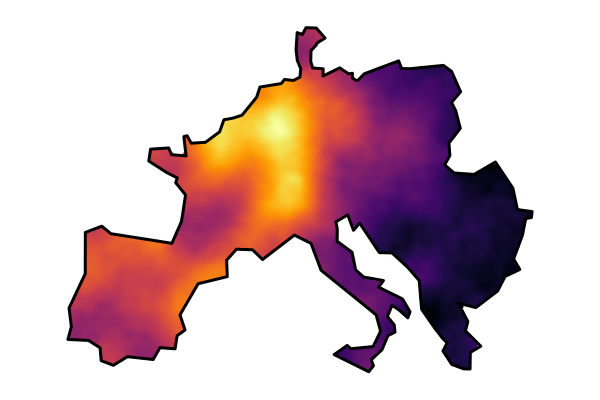

In [268]:
println(sum(mred))
sum(pred)
println(sum(pred)*dx^2)
println(sum(p0))
#hm_plot(contmod, contmod.m; borders=[border])
#temp = zeros(size(mred))
#temp[isgrid]
hm_plot(contmod, bxred; borders=[border])
#minimum(mred)

In [269]:
# compute or load grid parameters
contmod2 = get_params(mesh, scale_factor, "../data/disc/pantagruel.h5", Niter=1,
    dmax = 2*dx, patch=4000.0, bmin=0.0, tau=0.00001);
contmod2.m = mred
contmod2.d = dred
contmod2.p = pred
contmod2.bx = bxred
contmod2.by = byred
contmod2.bx = max.(contmod2.bx, mean(contmod2.bx[contmod.isgrid])) # the graph that I created is offset for bs
contmod2.by = max.(contmod2.by, mean(contmod2.by[contmod.isgrid])); #
update_params!(contmod2)


  1.895082 seconds (529.81 k allocations: 16.811 GiB, 4.16% gc time)
  0.135149 seconds (1.18 k allocations: 218.564 MiB)


In [270]:
println(minimum(contmod2.m[contmod2.isgrid]))

29.079817650509998


In [271]:
# get stable solution
compute_stable_sol!(contmod2, interval = 10000, Niter = 250000, tol = 1e-7);

[10000.0 7.5532299581349e-5]
[20000.0 2.361694648911339e-5]
[30000.0 7.466589324600648e-6]
[40000.0 3.4760724157978373e-6]
[50000.0 2.20627369440507e-6]
[60000.0 1.443492853248074e-6]
[70000.0 9.773377939170658e-7]
[80000.0 6.911445007418138e-7]
[90000.0 5.154310617205837e-7]
[100000.0 4.0768297249194063e-7]
[110000.0 3.4170022644719467e-7]
[120000.0 3.013379025196272e-7]
[130000.0 2.766675540888386e-7]
[140000.0 2.615967954477938e-7]
[150000.0 2.5239367829055226e-7]
[160000.0 2.4677505283676737e-7]
[170000.0 2.433453418770881e-7]
[180000.0 2.412519941596969e-7]
[190000.0 2.3997438491907275e-7]
[200000.0 2.3919466785038423e-7]
[210000.0 2.3871882393056154e-7]
[220000.0 2.3842843155374993e-7]
[230000.0 2.3825121608922473e-7]
[240000.0 2.3814306848723987e-7]
[250000.0 2.3807707116851873e-7]
 23.661140 seconds (1.51 M allocations: 81.654 GiB, 1.87% gc time)


In [272]:
add_local_disturbance!(contmod2, [-0.35; 0.24], -10.0, 0.02, dx);
println(sum(contmod2.p)*dx^2)

-10.000000000000023


In [117]:
println(minimum(contmod2.m))
println(minimum(contmod.m))

0.0
0.0


In [273]:

t_red, th_red, o_red = perform_dyn_sim(contmod2, interval=2,
    Ndt=1000, dt=0.01, method="cn");

Total time: 10.0
NIter: 2 Avg. Omega: -0.002016525434972156
NIter: 4 Avg. Omega: -0.004011294935720133
NIter: 6 Avg. Omega: -0.005986962076772579
NIter: 8 Avg. Omega: -0.007955792907472635
NIter: 10 Avg. Omega: -0.009935091424649194
NIter: 12 Avg. Omega: -0.01194207201554769
NIter: 14 Avg. Omega: -0.013991273970781563
NIter: 16 Avg. Omega: -0.016092891187452364
NIter: 18 Avg. Omega: -0.01825225546578891
NIter: 20 Avg. Omega: -0.020471073554524297
NIter: 22 Avg. Omega: -0.0227466499256679
NIter: 24 Avg. Omega: -0.025071648085629127
NIter: 26 Avg. Omega: -0.02743587834141086
NIter: 28 Avg. Omega: -0.029829171632738728
NIter: 30 Avg. Omega: -0.03224270261302071
NIter: 32 Avg. Omega: -0.03466698055988315
NIter: 34 Avg. Omega: -0.037088236251059094
NIter: 36 Avg. Omega: -0.03948793711656105
NIter: 38 Avg. Omega: -0.041846569660809296
NIter: 40 Avg. Omega: -0.04414805071175506
NIter: 42 Avg. Omega: -0.046381021823883525
NIter: 44 Avg. Omega: -0.04853639107589602
NIter: 46 Avg. Omega: -0.0506

NIter: 378 Avg. Omega: -0.12834935255720112
NIter: 380 Avg. Omega: -0.1300023136377221
NIter: 382 Avg. Omega: -0.13164186446270923
NIter: 384 Avg. Omega: -0.13327358895760885
NIter: 386 Avg. Omega: -0.13489704661289434
NIter: 388 Avg. Omega: -0.1365104909200318
NIter: 390 Avg. Omega: -0.13811642993482504
NIter: 392 Avg. Omega: -0.1397178050144525
NIter: 394 Avg. Omega: -0.14131222666431065
NIter: 396 Avg. Omega: -0.14289115885889617
NIter: 398 Avg. Omega: -0.1444444645919828
NIter: 400 Avg. Omega: -0.14595753082074978
NIter: 402 Avg. Omega: -0.14741223415429303
NIter: 404 Avg. Omega: -0.14878953100299905
NIter: 406 Avg. Omega: -0.15006927148742377
NIter: 408 Avg. Omega: -0.1512369550647312
NIter: 410 Avg. Omega: -0.15228901917438967
NIter: 412 Avg. Omega: -0.1532239265129897
NIter: 414 Avg. Omega: -0.15403490644346898
NIter: 416 Avg. Omega: -0.15471135460541474
NIter: 418 Avg. Omega: -0.15524768983362858
NIter: 420 Avg. Omega: -0.1556470898818825
NIter: 422 Avg. Omega: -0.1559202709234

NIter: 754 Avg. Omega: -0.16230351069105356
NIter: 756 Avg. Omega: -0.16237654311841754
NIter: 758 Avg. Omega: -0.16244710512784954
NIter: 760 Avg. Omega: -0.16251876883048738
NIter: 762 Avg. Omega: -0.1625992302729813
NIter: 764 Avg. Omega: -0.16269748621975316
NIter: 766 Avg. Omega: -0.16281941880114148
NIter: 768 Avg. Omega: -0.16296567338347628
NIter: 770 Avg. Omega: -0.1631322816313617
NIter: 772 Avg. Omega: -0.16331276452684165
NIter: 774 Avg. Omega: -0.16350190764999487
NIter: 776 Avg. Omega: -0.16369694627598796
NIter: 778 Avg. Omega: -0.16389482018941087
NIter: 780 Avg. Omega: -0.1640917958336671
NIter: 782 Avg. Omega: -0.16428820573797556
NIter: 784 Avg. Omega: -0.16448832483082657
NIter: 786 Avg. Omega: -0.16469589101938542
NIter: 788 Avg. Omega: -0.16491105533153655
NIter: 790 Avg. Omega: -0.1651304794856158
NIter: 792 Avg. Omega: -0.1653489065907057
NIter: 794 Avg. Omega: -0.1655614596381874
NIter: 796 Avg. Omega: -0.16576515385793608
NIter: 798 Avg. Omega: -0.165959344415

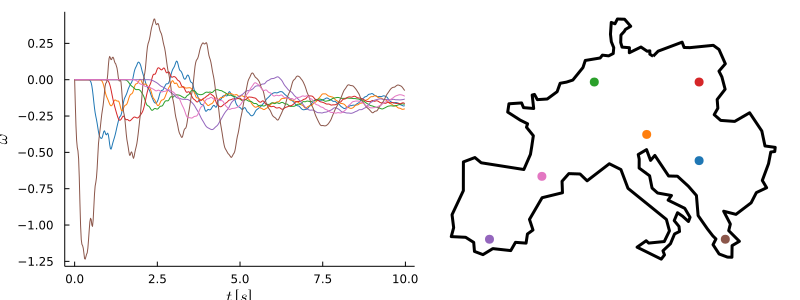

In [229]:
# check what's going on
c = [500 -250; 0.0 0.0; -500 500; 500. 500.; -1500.0 -1000.0; 750.0 -1000; -1000 -400] / scale_factor
#c = [-1500.0 -1000.0] / scale_factor
time_plot(contmod2, t_red, o_red, c, borders = [border], tstart = 0.0, tend = 10.0)

In [238]:
# now with the full model for comparison
# get stable solution
compute_stable_sol!(contmod, interval = 10000, Niter = 250000, tol = 1e-7);


[10000.0 8.967022522066159e-5]
[20000.0 1.680045517837847e-5]
[30000.0 7.5607218059103865e-6]
[40000.0 4.468156176606897e-6]
[50000.0 2.6686238522311e-6]
[60000.0 1.6090509438182465e-6]
[70000.0 9.826666907963855e-7]
[80000.0 6.119008549854144e-7]
[90000.0 3.9236106474938026e-7]
[100000.0 2.623562070924734e-7]
[110000.0 1.8537128088080834e-7]
[120000.0 1.39783814301353e-7]
[130000.0 1.1278904166189818e-7]
[140000.0 9.68041325988267e-8]
 13.294675 seconds (843.00 k allocations: 45.726 GiB, 1.80% gc time)


In [239]:
add_local_disturbance!(contmod, [-0.35; 0.24], -10.0, 0.02, dx);
println(sum(contmod.p)*dx^2)

-9.999999999999895


In [240]:
t_full, th_full, o_full = perform_dyn_sim(contmod, interval=2,
    Ndt=1000, dt=0.01, method="cn");

Total time: 10.0
NIter: 2 Avg. Omega: -0.0022097121090704
NIter: 4 Avg. Omega: -0.004409031500627065
NIter: 6 Avg. Omega: -0.006603249998395139
NIter: 8 Avg. Omega: -0.008795753914218152
NIter: 10 Avg. Omega: -0.010987502432075113
NIter: 12 Avg. Omega: -0.013176912188628478
NIter: 14 Avg. Omega: -0.015360196187814947
NIter: 16 Avg. Omega: -0.017532139094475097
NIter: 18 Avg. Omega: -0.019687236821386695
NIter: 20 Avg. Omega: -0.021821005172415805
NIter: 22 Avg. Omega: -0.023931186082948325
NIter: 24 Avg. Omega: -0.02601856500228442
NIter: 26 Avg. Omega: -0.0280872009308642
NIter: 28 Avg. Omega: -0.0301440445450396
NIter: 30 Avg. Omega: -0.03219806862247326
NIter: 32 Avg. Omega: -0.03425910032784079
NIter: 34 Avg. Omega: -0.03633654671809075
NIter: 36 Avg. Omega: -0.03843822803066809
NIter: 38 Avg. Omega: -0.040569507869418237
NIter: 40 Avg. Omega: -0.042732832813615854
NIter: 42 Avg. Omega: -0.04492769065946983
NIter: 44 Avg. Omega: -0.047150921090759364
NIter: 46 Avg. Omega: -0.049397

NIter: 378 Avg. Omega: -0.06022115725964879
NIter: 380 Avg. Omega: -0.06122406649147695
NIter: 382 Avg. Omega: -0.0623019853637703
NIter: 384 Avg. Omega: -0.06345863785287452
NIter: 386 Avg. Omega: -0.06469544210475034
NIter: 388 Avg. Omega: -0.06601168128262369
NIter: 390 Avg. Omega: -0.06740519187151454
NIter: 392 Avg. Omega: -0.06887307362675511
NIter: 394 Avg. Omega: -0.07041229827912834
NIter: 396 Avg. Omega: -0.07202014556602612
NIter: 398 Avg. Omega: -0.07369414658464384
NIter: 400 Avg. Omega: -0.07543136877063397
NIter: 402 Avg. Omega: -0.07722745087670316
NIter: 404 Avg. Omega: -0.07907608228570803
NIter: 406 Avg. Omega: -0.08096918293348877
NIter: 408 Avg. Omega: -0.08289750943897364
NIter: 410 Avg. Omega: -0.08485151870523054
NIter: 412 Avg. Omega: -0.08682258863388619
NIter: 414 Avg. Omega: -0.08880437317536424
NIter: 416 Avg. Omega: -0.0907936436544754
NIter: 418 Avg. Omega: -0.09279024714855384
NIter: 420 Avg. Omega: -0.09479631398869516
NIter: 422 Avg. Omega: -0.09681483

NIter: 754 Avg. Omega: -0.15819446040495722
NIter: 756 Avg. Omega: -0.1578648736434696
NIter: 758 Avg. Omega: -0.15756357464218215
NIter: 760 Avg. Omega: -0.15729234182280383
NIter: 762 Avg. Omega: -0.15705038145402292
NIter: 764 Avg. Omega: -0.1568351537476823
NIter: 766 Avg. Omega: -0.1566434195228525
NIter: 768 Avg. Omega: -0.15647214512112873
NIter: 770 Avg. Omega: -0.15631911554160585
NIter: 772 Avg. Omega: -0.15618316302113736
NIter: 774 Avg. Omega: -0.15606392390834078
NIter: 776 Avg. Omega: -0.1559612795167608
NIter: 778 Avg. Omega: -0.15587475547180732
NIter: 780 Avg. Omega: -0.15580300217098378
NIter: 782 Avg. Omega: -0.15574337107209382
NIter: 784 Avg. Omega: -0.1556917797428646
NIter: 786 Avg. Omega: -0.1556430953510233
NIter: 788 Avg. Omega: -0.15559194239999713
NIter: 790 Avg. Omega: -0.15553354179840492
NIter: 792 Avg. Omega: -0.15546421630672236
NIter: 794 Avg. Omega: -0.15538136314477197
NIter: 796 Avg. Omega: -0.15528289620823976
NIter: 798 Avg. Omega: -0.155166473313

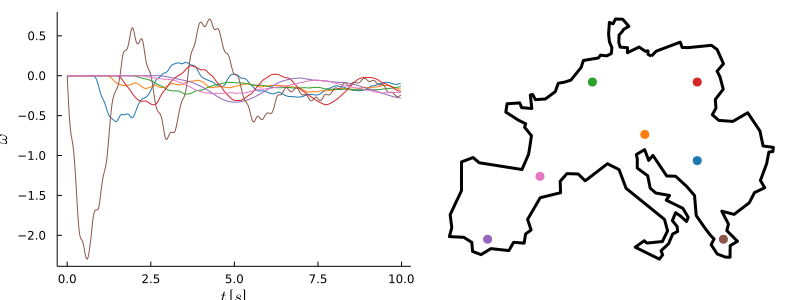

In [241]:
c = [500 -250; 0.0 0.0; -500 500; 500. 500.; -1500.0 -1000.0; 750.0 -1000; -1000 -400] / scale_factor
#c = [-1500.0 -1000;] / scale_factor
time_plot(contmod, t_full, o_full, c, borders = [border], tstart = 0.0, tend = 10.0)

In [242]:
id = Int64.(zeros(size(c,1)))
grid_coord = contmod.coord[contmod.isgrid,:] 
for i in 1:length(id)
    id[i] = argmin((grid_coord[:,1] .- c[i,2]).^2 + (grid_coord[:,2] .- c[i,1]).^2)
end

In [280]:
gps_coord=[42.65350168704794 22.77718232473864; 50.278232 19.217612;
    45.862612335292795 4.8914400255362915;
    39.84581436366348 -5.787270913610404]

id = find_node(contmod,gps_coord, scale_factor=scale_factor)

plot(t_full, o_full[id,:]')
plot!(t_red, o_red[id,:]')

LoadError: Expects 501 elements in each col of y, found 4.

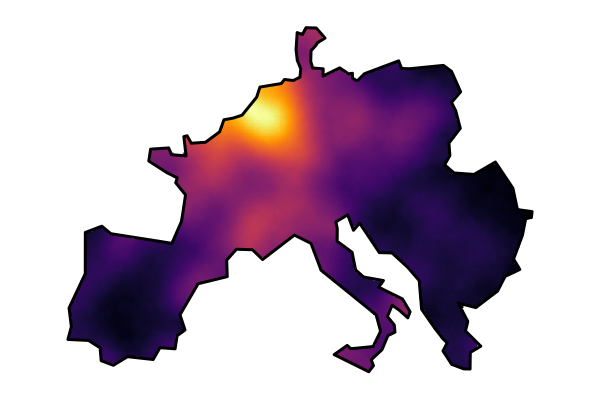

In [249]:
hm_plot(contmod, contmod2.m; borders=[border])

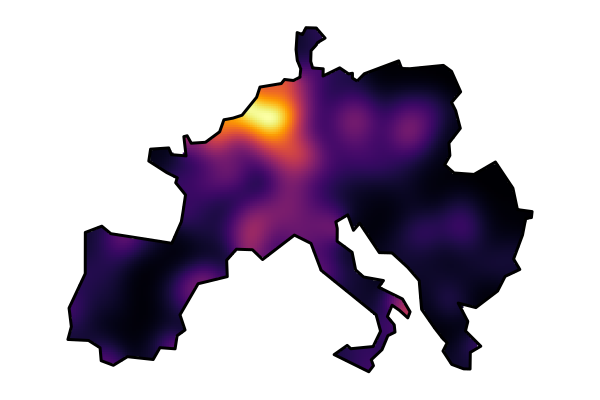

In [250]:
hm_plot(contmod, contmod.m; borders=[border])